In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.special import gamma
from pynverse import inversefunc as inv
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.stattools import coint
from hurst import compute_Hc
import sys
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
pd.options.display.float_format = '{:,.8f}'.format


# 
def read_stocks_prices(filename: str):
    df_prices = pd.read_excel(filename, index_col=0)
    df_prices.index = pd.to_datetime(df_prices.index)
    df_prices = df_prices.dropna(axis=1)
    stocks = df_prices.columns
    return stocks, df_prices


def calc_normPrices(df_prices):
    df_normPrices = (df_prices-df_prices.min()) / \
        (df_prices.max()-df_prices.min())
    return df_normPrices


def calc_returns(df_prices):
    df_returns = df_prices.pct_change().fillna(0)
    return df_returns


def calc_logReturns(df_prices):
    df_logReturns = (np.log(df_prices).diff()).fillna(0)
    return df_logReturns


def calc_cumlogReturns(df_prices):
    df_cumlogReturns = (np.log(df_prices).diff().cumsum()
                        ).fillna(0)
    return df_cumlogReturns


# calculate kendalls tau
def calc_tau(stocks: list, df_data: pd.DataFrame) -> pd.DataFrame:
    '''
    Calculate tau of all the pairs formed by given stocks
    para:
    - stocks: list, list of stocks
    - df_data: pd.Dataframe, time series data to be used for pair trading
    return:
    - df_tau_results: pd.DataFrame, tau values in ascending order
    '''
    df_tau_results = pd.DataFrame(columns=['tau'])
    l = len(stocks)
    for i in range(l-1):
        for j in range(i+1, l):
            if (stocks[i] != stocks[j]) and (f'{stocks[i]}-{stocks[j]}' not in df_tau_results.index):
                df_tau_results.loc[f'{stocks[i]}-{stocks[j]}'] = stats.kendalltau(
                    df_data[stocks[i]], df_data[stocks[j]])[0]
    df_tau_results.sort_values(by='tau', inplace=True)

    return df_tau_results


# select pairs with high kendall's tau
def parse_pair(pair: str) -> str:
    '''
    Helper function to parse the pairs' name(str)
    para:
    - pair: str, a pair in the form of 'A-B'
    '''
    stock_1 = pair[:pair.find('-')]
    stock_2 = pair[pair.find('-')+1:]
    return stock_1, stock_2


# select pais using tau
def select_pairs(df_data_form, df_tau_results: pd.DataFrame) -> list:
    '''
    Select pairs according to the pair's tau value
    para:
    - stocks: list, list of stocks
    - df_tau_results: pd.DataFrame, pairs' tau results calculated by calc_tau(.)
    return:
    - stocks_selcted: list, list of stocks that satisfy the tau requirement
    - pairs_selected: list, list of pairs formed by the selected stocks
    '''
    def pairs_by_tau(df_tau_results):
        pairs_selected = []
        for pair in df_tau_results.sort_values(by='tau', ascending=False).index:
            # tau
            tau_score = df_tau_results['tau'][pair]
            if tau_score < 0.8:
                break
            pairs_selected.append([pair, tau_score])
        pairs_selected = np.array(
            sorted(pairs_selected, key=lambda x: x[1], reverse=True))[:, 0]
        return pairs_selected

    def pairs_by_distance(df_data_form, pairs):
        pairs_selected = []
        for pair in pairs:
            stock_1, stock_2 = parse_pair(pair)
            S1_form, S2_form = df_data_form[stock_1], df_data_form[stock_2]
            # distance
            diff = S1_form - S2_form
            distance_score = (diff * diff).sum()
            pairs_selected.append([pair, distance_score])

        pairs_selected = np.array(
            sorted(pairs_selected, key=lambda x: x[1]))[:, 0]
        return pairs_selected

    def pairs_by_cointegration(df_data_form, pairs):
        pairs_selected = []
        for pair in pairs:
            stock_1, stock_2 = parse_pair(pair)
            S1_form, S2_form = df_data_form[stock_1], df_data_form[stock_2]
            # cointegration
            conin_p_score = coint(S1_form, S2_form)[1]

            if conin_p_score < 0.05:
                pairs_selected.append([pair, conin_p_score])

        pairs_selected = np.array(
            sorted(pairs_selected, key=lambda x: x[1]))[:, 0]
        return pairs_selected

    def pairs_by_hurst(df_data_form, pairs):

        pairs_selected = []
        for pair in pairs:
            stock_1, stock_2 = parse_pair(pair)
            S1_form, S2_form = df_data_form[stock_1], df_data_form[stock_2]
            # compute spread
            spread_form = S1_form - S2_form
            hurst_score = compute_Hc(spread_form)[0]
            if hurst_score < 0.5:
                pairs_selected.append([pair, hurst_score])

        pairs_selected = np.array(
            sorted(pairs_selected, key=lambda x: x[1]))[:, 0]
        return pairs_selected

    pairs_1 = pairs_by_tau(df_tau_results)
    pairs_2 = pairs_by_distance(df_data_form, pairs_1)
    pairs_3 = pairs_by_cointegration(df_data_form, pairs_2)
    pairs_4 = pairs_by_hurst(df_data_form, pairs_3)
    print(len(pairs_1), len(pairs_2), len(pairs_3), len(pairs_4))
    return pairs_4


/Users/ritaw/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# UPDATED!!!!!!!!!
from copulae.archimedean import GumbelCopula, FrankCopula, ClaytonCopula
from copulae.elliptical import GaussianCopula, StudentCopula
from copulae.mixtures.gmc.gmc import GaussianMixtureCopula
from scipy.stats import norm
from scipy.stats import t
from statistics import NormalDist


def fit_copula(df_data, pairs_selected):
    df_copula_results = pd.DataFrame(index=pairs_selected, columns=[
                                     'copula', 'parameter', 'aic', 'bic'])

    for pair in pairs_selected:
        s1, s2 = parse_pair(pair)
        u, v = ECDF(df_data[s1])(df_data[s1]), ECDF(df_data[s2])(df_data[s2])

        data_selected = pd.DataFrame(data={s1: u, s2: v}, columns=[s1, s2])
        _, ndim = data_selected.shape

        best_aic = np.inf

        for copula in [GumbelCopula(dim=ndim), FrankCopula(dim=ndim), ClaytonCopula(dim=ndim), GaussianCopula(dim=ndim), StudentCopula(dim=ndim)]:
            copula.fit(data_selected)
            L = copula.log_lik(data_selected)
            param = copula.params
            num_params = 1
            if isinstance(param, np.ndarray):
                num_params = len(param)
            aic = 2 * num_params - 2 * L
            if aic < best_aic:
                best_aic = aic
                best_bic = num_params * np.log(len(u)) - 2 * L
                best_copula = copula.name

                if isinstance(copula, StudentCopula):
                    best_param = [copula.params[0], copula.params[1][0]]
                else:
                    best_param = copula.params

        df_copula_results.loc[pair] = [
            best_copula, best_param, best_aic, best_bic]
    return df_copula_results


def copula_params(df_data_reform, df_tau_results: pd.DataFrame, pair: str, family: str) -> float:
    '''
    Calculate the parameter Theta of specific copula functions
    para:
    - family: str, name of copula function
    - stock_1: str, component 1 of a pair, which is an equity stock
    - stock_2: str, component 2 of a pair, which is an equity stock
    '''
    tau = df_tau_results['tau'][pair]
    rho = np.sin(np.pi/2*tau)

    if family == 'Clayton':
        return 2*tau/float(1-tau)
    elif family == 'Frank':
        def integrand(t): return t/(np.exp(t)-1)
        def frank_fun(theta): return ((tau - 1)/4.0 - (quad(integrand,
                                                            sys.float_info.epsilon, theta)[0]/theta - 1)/theta)**2
        return minimize(frank_fun, 4, method='BFGS', tol=1e-5).x[0]
    elif family == 'Gumbel':
        return 1/(1-tau)
    elif family == 'Gaussian':
        return rho
    elif family == 'Student':
        s1, s2 = parse_pair(pair)
        u, v = ECDF(df_data_reform[s1])(df_data_reform[s1]), ECDF(
            df_data_reform[s2])(df_data_reform[s2])
        data_selected = pd.DataFrame(data={s1: u, s2: v}, columns=[s1, s2])
        copula = StudentCopula(dim=2)
        copula.fit(data_selected)
        L = copula.log_lik(data_selected)
        if isinstance(copula, StudentCopula):
            return [copula.params[0], copula.params[1][0]]


def calc_MPI(family, theta, U: np.array, V: np.array):
    if family == 'Clayton':
        A_v = np.power(V, -theta - 1)  # C(u|v)
        A_u = np.power(U, -theta - 1)  # C(v|u)
        # If theta tends to inf, A tends to inf, And the next partial_derivative tends to 0
        if (A_v == np.inf).any():
            MPI_u_v = np.zeros(len(V))
        if (A_u == np.inf).any():
            MPI_v_u = np.zeros(len(U))

        B = np.power(V, -theta) + np.power(U, -theta) - 1
        h = np.power(B, (-1 - theta) / theta)
        MPI_u_v = A_v * h
        MPI_v_u = A_u*h

    elif family == 'Frank':
        if theta == 0:
            return V
        else:
            A = (np.exp(-theta * U) - 1) * \
                (np.exp(-theta * V) - 1) + (np.exp(-theta * V) - 1)
            B = (np.exp(-theta * U) - 1) * \
                (np.exp(-theta * V) - 1) + (np.exp(-theta * U) - 1)
            C = (np.exp(-theta * U) - 1) * \
                (np.exp(-theta * V) - 1) + (np.exp(-theta) - 1)
            if C == 0.0:
                return 0.5, 0.5
            MPI_u_v = B / C
            MPI_v_u = A / C

    elif family == 'Gumbel':
        if theta == 1:
            return V
        else:
            t1 = np.power(-np.log(U), theta)
            t2 = np.power(-np.log(V), theta)
            p1 = U * V if theta == 1 else np.exp(-np.power(
                np.power(-np.log(U), theta) + np.power(-np.log(V), theta), 1.0 / theta))
            p2 = np.power(t1 + t2, -1 + 1.0 / theta)
            MPI_u_v = p1 * p2 * np.power(-np.log(V), theta - 1) / V
            MPI_v_u = p1 * p2 * np.power(-np.log(U), theta - 1) / U

    elif family == 'Gaussian':
        MPI_u_v = norm.cdf(norm.ppf(U)-theta*norm.ppf(V) / np.sqrt(1-theta**2))
        MPI_v_u = norm.cdf(norm.ppf(V)-theta*norm.ppf(U) / np.sqrt(1-theta**2))

    elif family == 'Student':
        n = theta[0]  # corr
        rho = theta[1]  # df
        MPI_u_v = t.cdf(np.sqrt((n+1) / (n+t.ppf(V, n)**2)) *
                        (t.ppf(U, n)-rho*t.ppf(V, n)) / np.sqrt(1-rho**2), n+1)
        MPI_v_u = t.cdf(np.sqrt((n+1) / (n+t.ppf(U, n)**2)) *
                        (t.ppf(V, n)-rho*t.ppf(U, n)) / np.sqrt(1-rho**2), n+1)
        if MPI_u_v is np.NaN or MPI_v_u is np.NaN:
            print('Error')

    return MPI_u_v, MPI_v_u


In [4]:
from decimal import Decimal
U = 0.93255474
V = 0.94510949
theta = 60.39
A = (np.exp(-theta * U) - 1) * (np.exp(-theta * V))
B = (np.exp(-theta * V) - 1) * (np.exp(-theta * U))
C = (np.exp(-theta * U) - 1) * (np.exp(-theta * V) - 1) + (np.exp(-theta) - 1)
A/C


-inf

In [5]:
A = (np.exp(-theta * U) - 1) * \
    (np.exp(-theta * V) - 1) + (np.exp(-theta * V) - 1)
B = (np.exp(-theta * U) - 1) * \
    (np.exp(-theta * V) - 1) + (np.exp(-theta * U) - 1)
C = (np.exp(-theta * U) - 1) * (np.exp(-theta * V) - 1) + (np.exp(-theta) - 1)
B


0.0

In [6]:

# form copula
def copula_formation(df_data_form, df_tau_results, pairs_selected):
    # fit copula and theta
    df_copula_results = fit_copula(df_data_form, pairs_selected)
    df_copula_results = pd.concat([df_copula_results, df_tau_results], axis=1)
    return df_copula_results


def copula_update(df_data_reform, df_copula_results, pair):
    stocks = list(parse_pair(pair))
    df_tau_results = calc_tau(stocks, df_data_reform)
    # reestimate theta
    family = df_copula_results['copula'][pair]
    theta = copula_params(df_data_reform, df_tau_results, pair, family)
    df_copula_results['parameter'][pair] = theta
    df_copula_results['tau'][pair] = df_tau_results['tau'][pair]

    return df_copula_results


In [7]:
def train_test_split(df_data,train_start,train_end, test_start, test_end):
    df_train = df_data[train_start:train_end]
    df_test = df_data[test_start:test_end]
    return df_train, df_test 


def copula_trading(df_data_form, df_data_trade, df_copula_results, pair, threshold):
    global df_data
    
    stock_1, stock_2 = parse_pair(pair)
    data_form = df_data_form.loc[:,[stock_1, stock_2]]
    data_trade = df_data_trade.loc[:,[stock_1, stock_2]]
    quantiles_u = ECDF(data_form[stock_1].append(pd.Series([-10**6,10**6])))
    quantiles_v = ECDF(data_form[stock_2].append(pd.Series([-10**6,10**6])))
    family = df_copula_results['copula'][pair]
    theta = df_copula_results['parameter'][pair]
    df_copula_results_cp = df_copula_results.copy()

    quantiles_res = {'Quantile_1':[],'Quantile_2':[]}
    MPI_res = {'MPI_1':[],'MPI_2':[]}
    CMPI_res = {'CMPI_1':[],'CMPI_2':[]}
    df_positions = pd.DataFrame(index=data_trade.index, columns=[
                                    stock_1, stock_2, 'Signal', 'Open/Close'])
    long = False
    short = False
    
    trade_start = df_data_trade.index[0]
    print(trade_start)
    for t in data_trade.index:
        if t == trade_start + relativedelta(months=1):
            df_data_reform = df_data[t-relativedelta(years=2):t]
            df_copula_results_cp = copula_update(df_data_reform, df_copula_results_cp, pair)
            theta = df_copula_results_cp.loc[pair, 'parameter'] # update theta
            trade_start = t
        # 1. Calculate quantiles of test data according to train data
        u = data_trade.loc[t,stock_1]
        v = data_trade.loc[t,stock_2]
        u_q = quantiles_u(u)
        v_q = quantiles_v(v)

        MPI_u_v, MPI_v_u = calc_MPI(family, theta, u_q, v_q)
        if MPI_u_v is np.NaN or MPI_v_u is np.NaN:
            print(u,v,theta)
            break
        MPI_u_v -= 0.5
        MPI_v_u -= 0.5
        if t == data_trade.index[0]:
            CMPI_u_v = MPI_u_v
            CMPI_v_u = MPI_v_u
        else:
            CMPI_u_v = MPI_u_v + CMPI_res['CMPI_1'][-1]
            CMPI_v_u = MPI_v_u + CMPI_res['CMPI_2'][-1]
            if abs(CMPI_u_v) >= 1.5 or abs(CMPI_v_u) >= 1.5:
                CMPI_u_v = 0.0
                CMPI_v_u = 0.0

        quantiles_res['Quantile_1'].append(u_q)
        quantiles_res['Quantile_2'].append(v_q)
        MPI_res['MPI_1'].append(MPI_u_v)
        MPI_res['MPI_2'].append(MPI_v_u)
        CMPI_res['CMPI_1'].append(CMPI_u_v)
        CMPI_res['CMPI_2'].append(CMPI_v_u)


        # find trading signals along with time
        # NOTE: can change the flag - MPI or CMPI
        if t == df_data_trade.index[-1]:
            df_positions.loc[t] = [0, 0, 'Close', 'Close']
            break
        # if long position is open
        if long:
            if (CMPI_u_v >= 0) or (CMPI_v_u <= 0):
                df_positions.loc[t] = [0, 0, 'Close', 'Close']
                long = False
            else:
                df_positions.loc[t] = [1, -1, 'Hold', 'Open']
        # if short position is open
        elif short:
            if (CMPI_u_v <= 0) or (CMPI_v_u >= 0):
                df_positions.loc[t] = [0, 0, 'Close', 'Close']
                short = False
            else:
                df_positions.loc[t] = [-1, 1, 'Hold', 'Open']
        # if no positions are open
        else:
            # Long asset1 is undervalued(CMPI<-0.6 / MPI<-0.45) and short asset2 is overvalued(CMPI>0.6 / MPI>0.45)
            if (CMPI_u_v < -threshold) and (CMPI_v_u > threshold):
                # long asset1 and short asset2
                df_positions.loc[t] = [1, -1, 'Buy', 'Open']
                long = True
            # short asset1 is overvalued(CMPI>0.6 / MPI>0.45)) and long asset2 is undervalued(CMPI<-0.6 / MPI<-0.45)
            elif (CMPI_u_v > threshold) and (CMPI_v_u < -threshold):
                # short asset1 and long asset2
                df_positions.loc[t] = [-1, 1, 'Sell', 'Open']
                short = True
            else:
                df_positions.loc[t] = [0, 0, 'Hold', 'Close']


    calculations_res = {**quantiles_res, **MPI_res, **CMPI_res}
    df_calculations = pd.DataFrame(calculations_res, index=data_trade.index)
    df_calculations.columns = ['Quantile_'+stock_1, 'Quantile_'+stock_2, 'MPI_'+stock_1, 'MPI_'+stock_2, 'CMPI_'+stock_1, 'CMPI_'+stock_2]
    print(family)
    print(df_calculations[df_calculations['CMPI_'+stock_1].isna()])
    print(df_positions.loc[df_positions['Signal']!='Hold',:])
    
    df_returns = df_positions[[stock_1, stock_2]].shift() * data_trade
    df_positions.columns = ['Position_'+stock_1, 'Position_'+stock_2, 'Signal', 'Open/Close']
    df_returns.columns = ['Return_'+stock_1, 'Return_'+stock_2]
    print(data_trade)
    print(df_returns)

    return df_calculations, df_positions, df_returns
        
        

In [8]:
# performance measure
def metrics(df_return):
    df_return_total = df_return.sum(axis=1)
    cum_return = df_return_total.sum(axis=0)
    wining_rate = len(
        df_return_total[df_return_total > 0]) / len(df_return_total)

    # maximum number of consecutive losses
    counter = 0
    max_score = 0
    for p in df_return_total:
        if p < 0:
            counter += 1
        else:
            if counter > 0:
                max_score = max(max_score, counter)
            counter = 0
    max_score = max(max_score, counter)  # transfer from float to Series
    # Max drawdown
    cumulative_df = df_return_total.cumsum() + 1
    index_end = np.argmax(np.maximum.accumulate(cumulative_df) / cumulative_df)
    max_drawdown = 1 - cumulative_df[index_end] / \
        np.max(cumulative_df[:index_end])
    maxdd = max_drawdown
    # yearly sharpe_ratio

    sharpe_ratio = np.mean(df_return_total) / np.std(df_return_total) * \
        np.sqrt(252) if np.std(df_return_total) != 0 else 0
    # Calmar ratio
    calmar_ratio = (cum_return * 2)/maxdd

    metrics_res = {'Cumulative_return': [cum_return], 'Max_drawdown': [maxdd],
                   'Maxnum_consecutive_losses': [max_score], 'Sharpe_ratio': [sharpe_ratio], 'Winning_Rate': [wining_rate],
                   'Calmar_ratio': [calmar_ratio]}
    performance_metrics = pd.DataFrame(data=metrics_res, index=['Metrics'])

    return performance_metrics


# Main Part

### read and preprocess data

In [9]:
filename = '2006_2022_Prices.xlsx'
stocks, df_prices = read_stocks_prices(filename)
df_data = calc_logReturns(df_prices)

form_start = datetime.datetime(2006, 1, 1)
form_end = datetime.datetime(2022, 1, 1)
trade_start = datetime.datetime(2022, 1, 1)
trade_end = datetime.datetime(2023, 1, 1)
df_data_form, df_data_trade = train_test_split(
df_data, form_start, form_end, trade_start, trade_end)


### select pairs

In [10]:
df_tau_results = calc_tau(stocks, df_data_form)
pairs_selected = select_pairs(df_data_form, df_tau_results)


25 25 25 25


In [11]:
pairs_selected


array(['^DJGSP-^HUI', '^DJI-^DJUS', '^DJUSS-^RUT', '^DJI-^DJUSL',
       '^DJUS-^DJUSL', '^DJUS-^OEX', '^MID-^RUT', '^DJI-^OEX',
       '^DJUSS-^MID', '^DJUS-^DJUSM', '^DJUSM-^DJUSS', '^DJUSM-^NYA',
       '^IMUS-^OEX', '^DJUSL-^NYA', '^IMUS-^XII', '^DJUSL-^OEX',
       '^DJUSM-^MID', '^DJUS-^NYA', '^DJUSL-^IMUS', '^DJUS-^IMUS',
       '^DJUS-^XII', '^DJA-^DJI', '^DJI-^XMI', '^DJUSL-^XII', '^OEX-^XII'],
      dtype='<U32')

### fit copula

In [12]:
df_copula_results = copula_formation(
    df_data_form, df_tau_results.loc[pairs_selected], pairs_selected)
df_copula_results.to_excel('copula_result.xlsx')
df_copula_results

              ^DJGSP           ^HUI
count 4,028.00000000 4,028.00000000
mean      0.50000000     0.50000000
std       0.28863930     0.28863930
min       0.00024820     0.00024820
25%       0.25012410     0.25012410
50%       0.50037230     0.50000000
75%       0.74987590     0.74987590
max       0.99975180     0.99975180
              ^DJGSP           ^HUI
count 4,028.00000000 4,028.00000000
mean      0.50000000     0.50000000
std       0.28863930     0.28863930
min       0.00024820     0.00024820
25%       0.25012410     0.25012410
50%       0.50037230     0.50000000
75%       0.74987590     0.74987590
max       0.99975180     0.99975180
              ^DJGSP           ^HUI
count 4,028.00000000 4,028.00000000
mean      0.50000000     0.50000000
std       0.28863930     0.28863930
min       0.00024820     0.00024820
25%       0.25012410     0.25012410
50%       0.50037230     0.50000000
75%       0.74987590     0.74987590
max       0.99975180     0.99975180
              ^DJGSP        

,copula,parameter,aic,bic,tau
^DJGSP-^HUI,Student,"[1.2698056890414477e-06, 0.9994652660565534]","-127,860.28398201","-127,853.98295675",0.85046100
^DJI-^DJUS,Student,"[3.5284060739826373e-07, 0.9999015475724695]","-140,977.68706645","-140,971.38604120",0.80116474
^DJUSS-^RUT,Student,"[1.8661645162509899e-06, 0.998412893551511]","-121,509.69596159","-121,503.39493634",0.87962441
^DJI-^DJUSL,Student,"[4.851759293877933e-06, 0.9559507524675432]","-99,114.41926791","-99,108.11824266",0.81266361
^DJUS-^DJUSL,Frank,56.37579936,-inf,-inf,0.93111782
^DJUS-^OEX,Student,"[2.914895914862825e-06, 0.9978541896866119]","-115,675.77172254","-115,669.47069729",0.88189425
^MID-^RUT,Student,"[3.4538786852778003e-07, 0.9997970413501165]","-141,278.28990524","-141,271.98887998",0.83054014
^DJI-^OEX,Student,"[8.816698580105253e-07, 0.9997695855905385]","-131,747.02904099","-131,740.72801573",0.81809367
^DJUSS-^MID,Frank,37.53915930,-inf,-inf,0.89811377
^DJUS-^DJUSM,Student,"[1.9073472494746113e-06, 0.9681531388948313]","-109,760.05316451","-109,753.75213926",0.84975342


In [13]:
# df_copula_results = pd.read_excel('copula_result.xlsx', index_col=0)
# df_copula_results


### trade

2022-01-03 00:00:00
            ^DJGSP         ^HUI
count 507.00000000 507.00000000
mean    0.50000000   0.50000000
std     0.28839087   0.28839073
min     0.00196850   0.00196850
25%     0.25098425   0.25098425
50%     0.50000000   0.50000000
75%     0.74901575   0.74901575
max     0.99803150   0.99803150
            ^DJGSP         ^HUI
count 506.00000000 506.00000000
mean    0.50000000   0.50000000
std     0.28839030   0.28839017
min     0.00197239   0.00197239
25%     0.25098619   0.25098619
50%     0.50000000   0.50000000
75%     0.74901381   0.74901381
max     0.99802761   0.99802761
Student
Empty DataFrame
Columns: [Quantile_^DJGSP, Quantile_^HUI, MPI_^DJGSP, MPI_^HUI, CMPI_^DJGSP, CMPI_^HUI]
Index: []
           ^DJGSP ^HUI Signal Open/Close
Date                                    
2022-04-14      1   -1    Buy       Open
2022-05-20      0    0  Close      Close
2022-12-30      0    0  Close      Close
                ^DJGSP        ^HUI
Date                              
2022-01

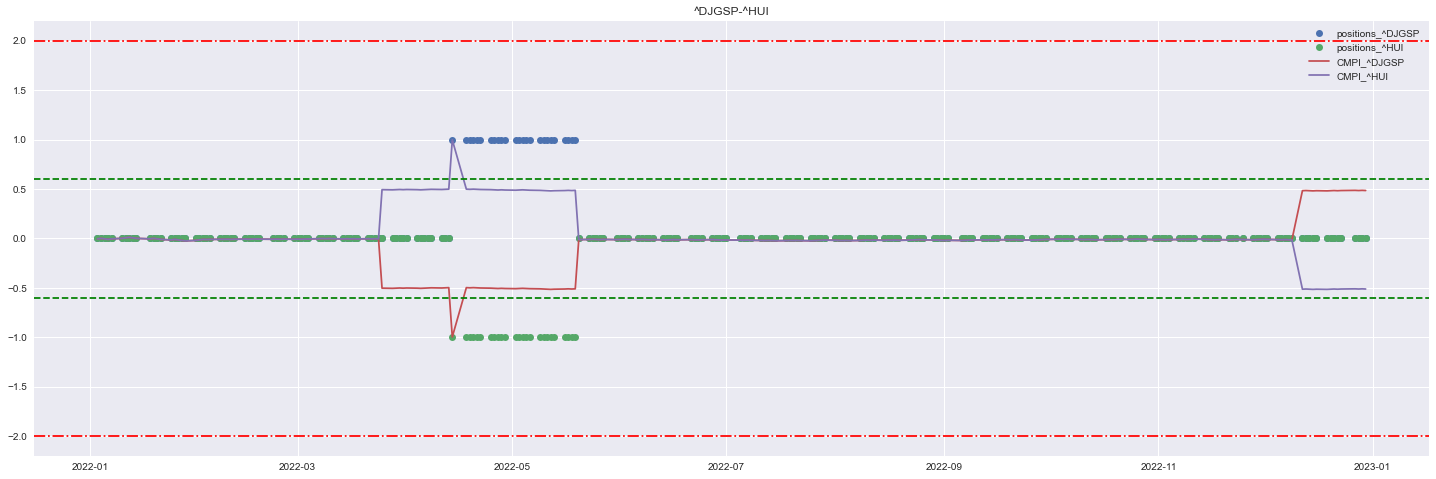

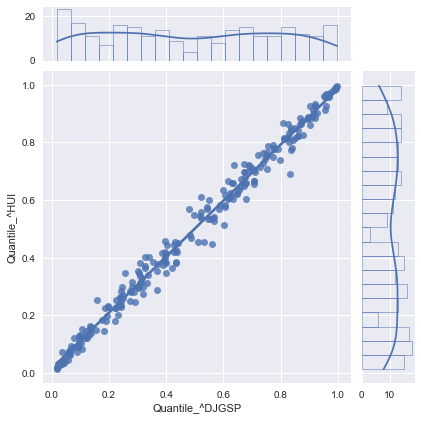

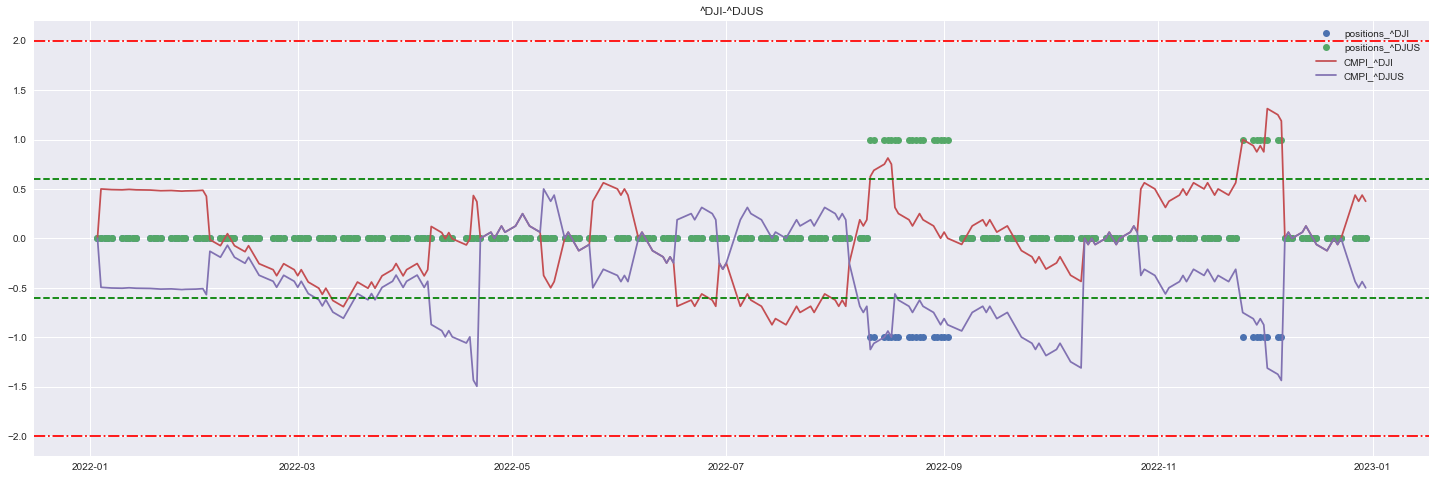

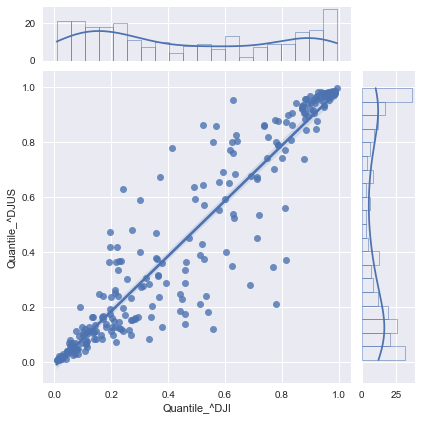

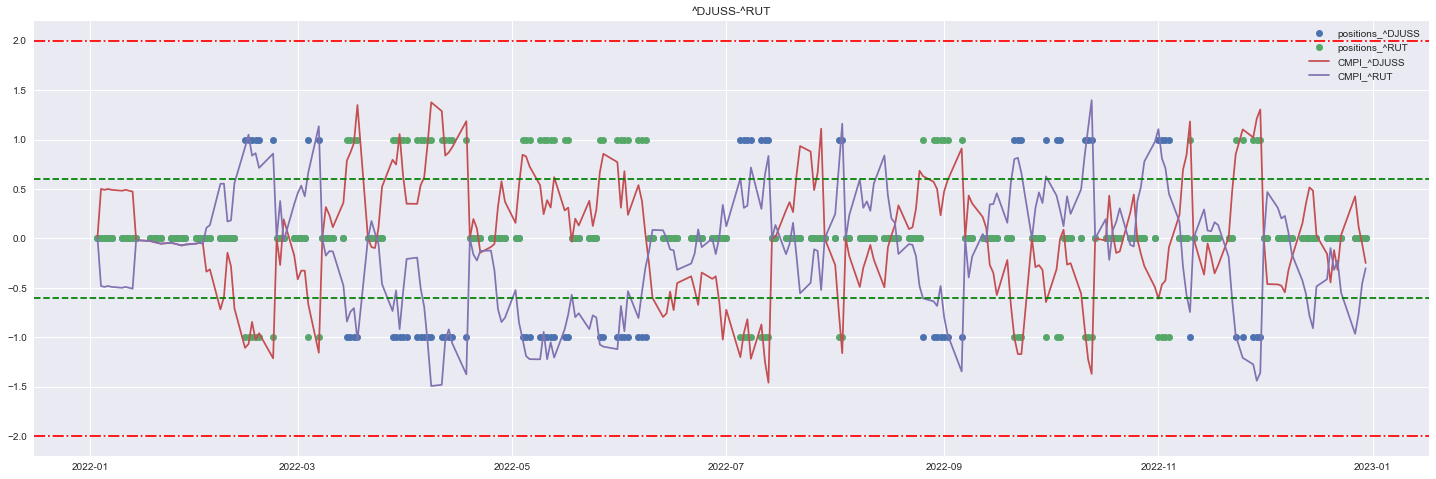

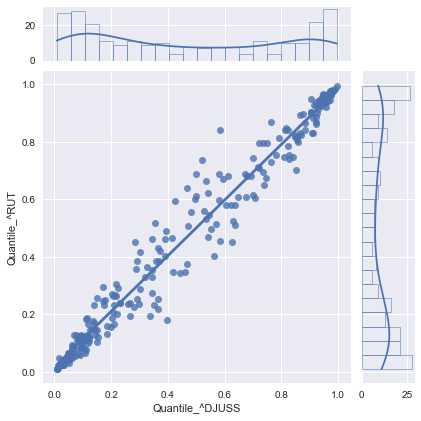

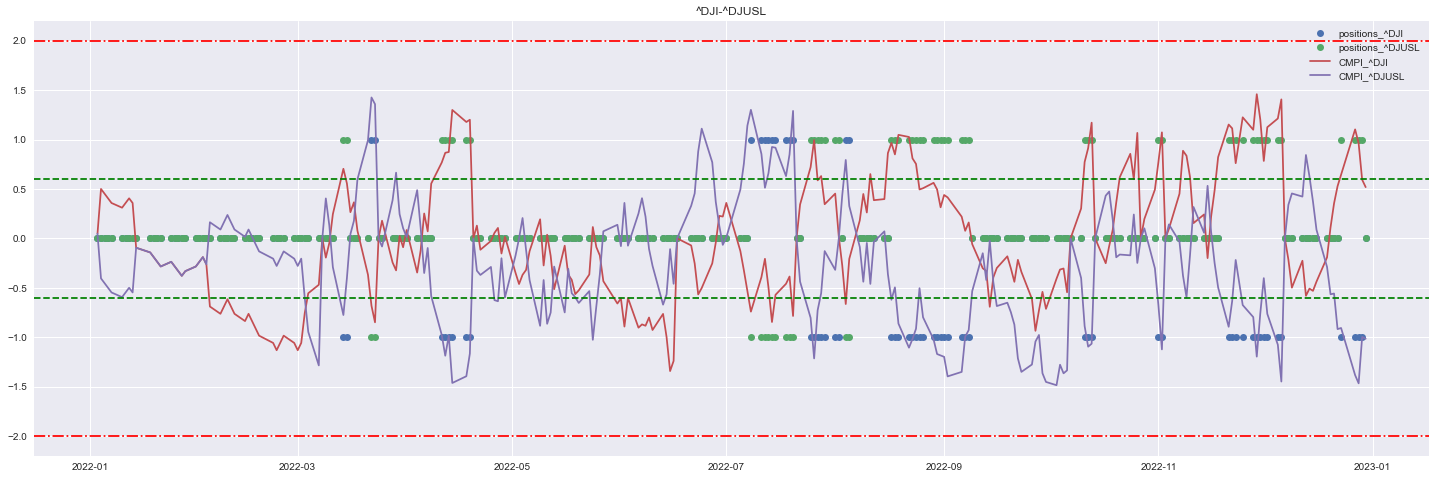

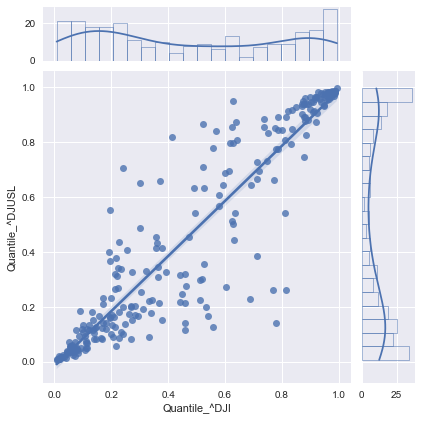

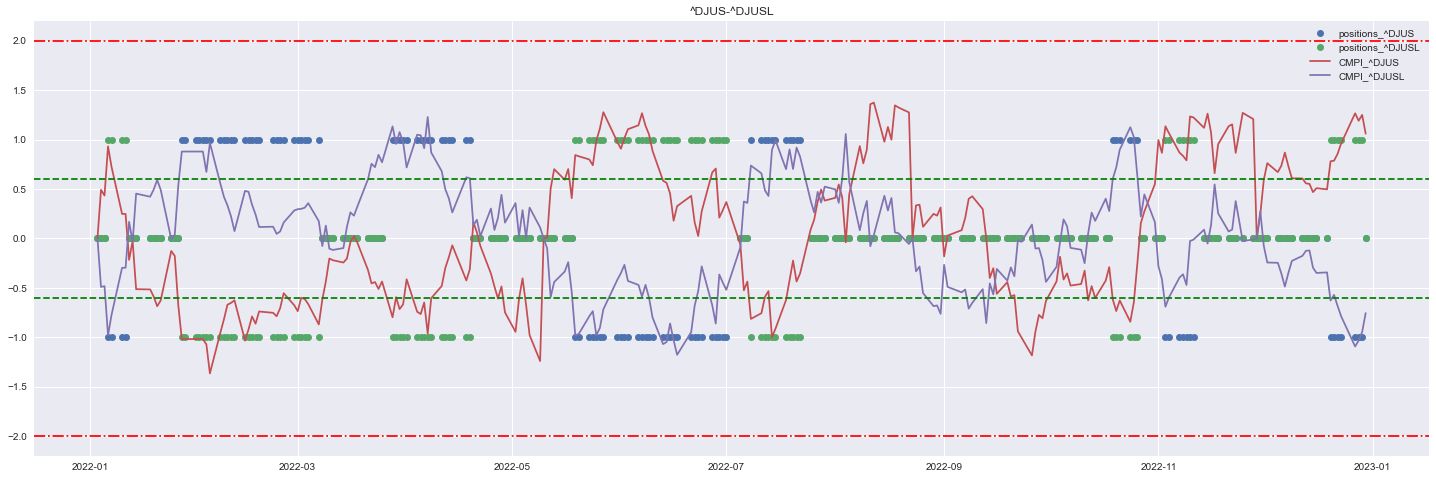

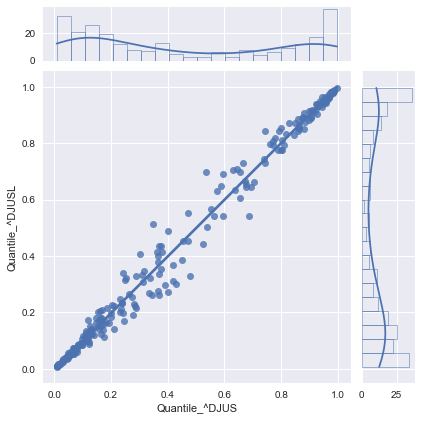

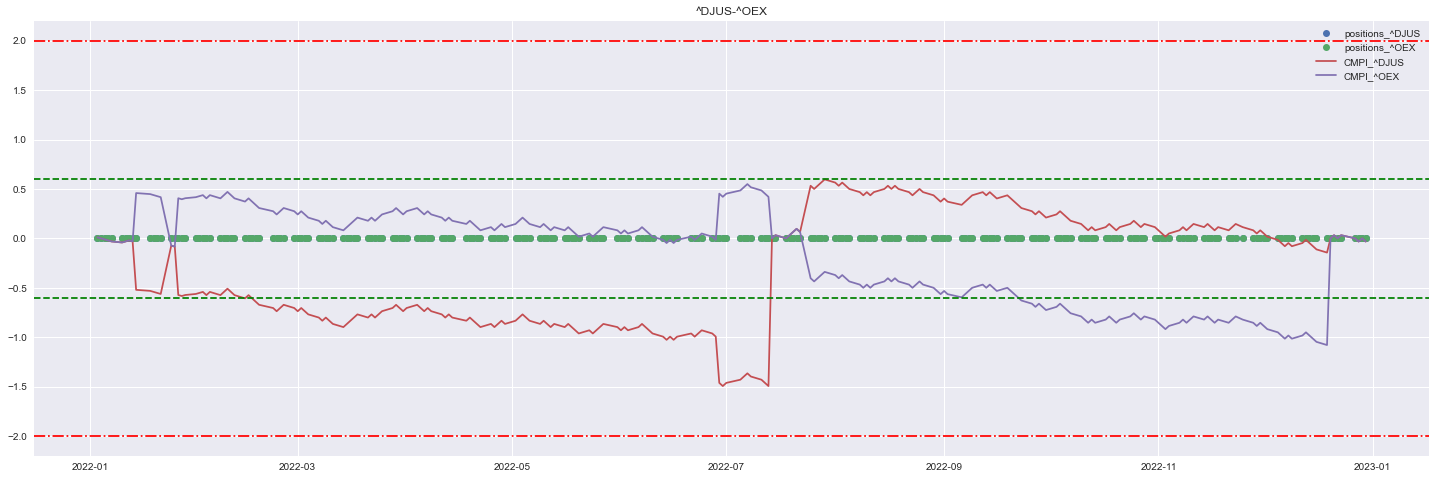

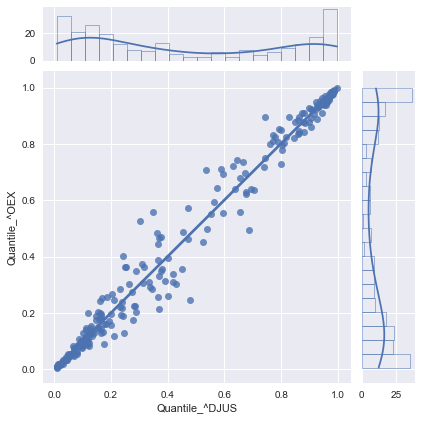

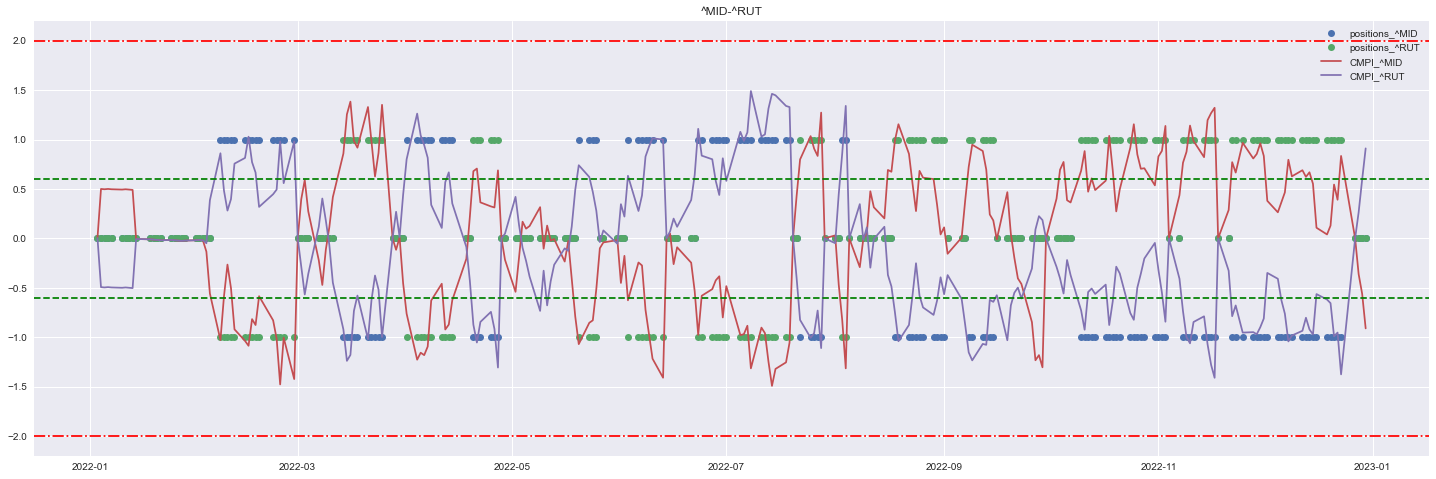

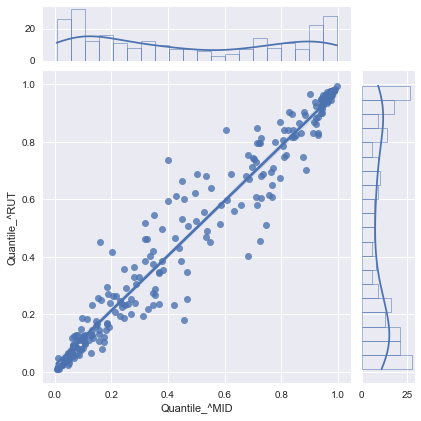

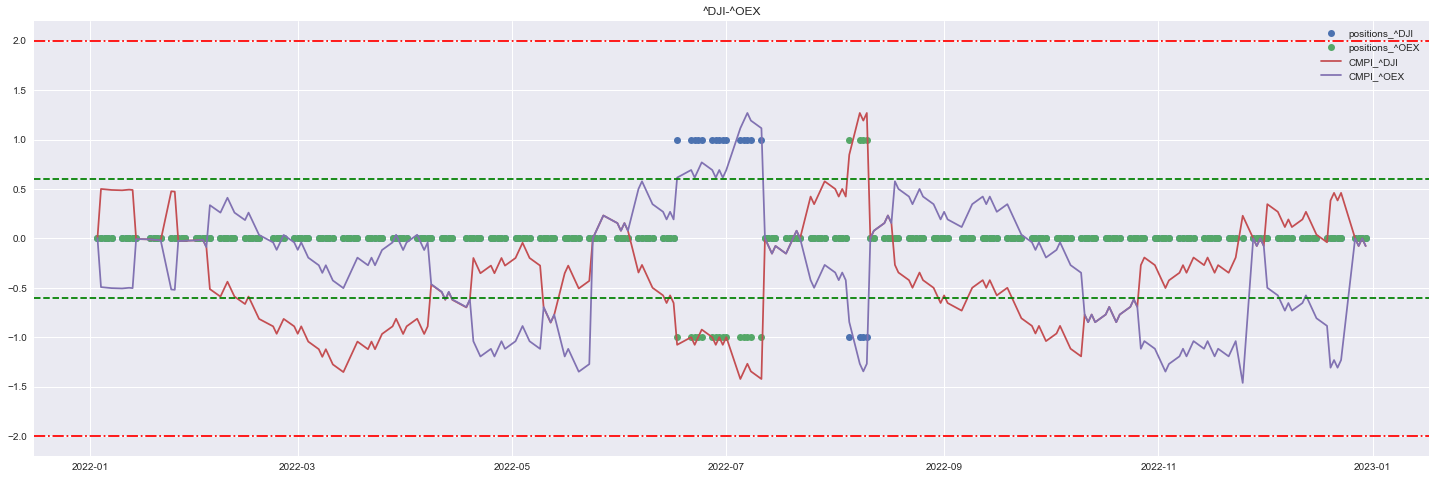

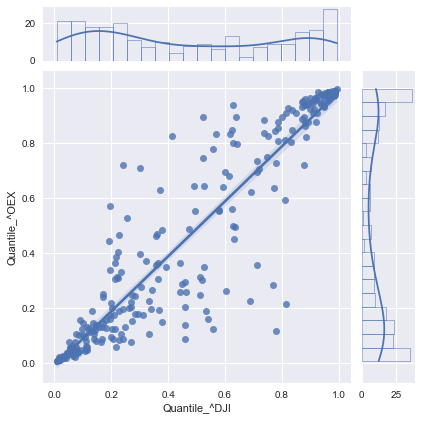

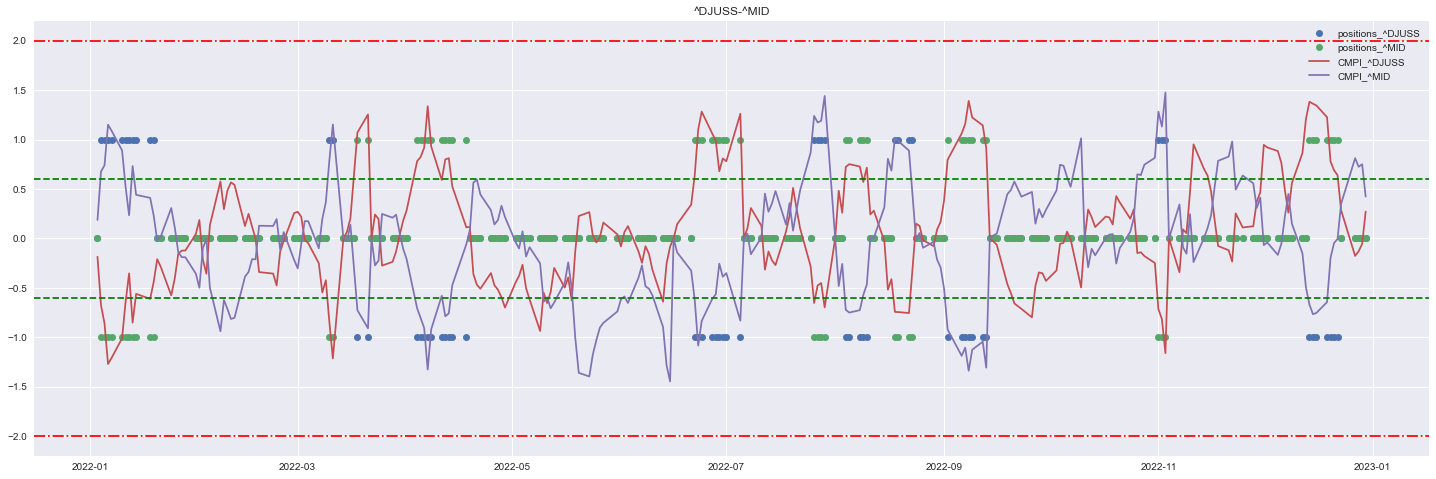

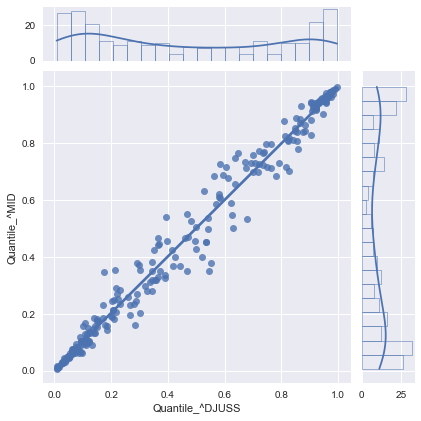

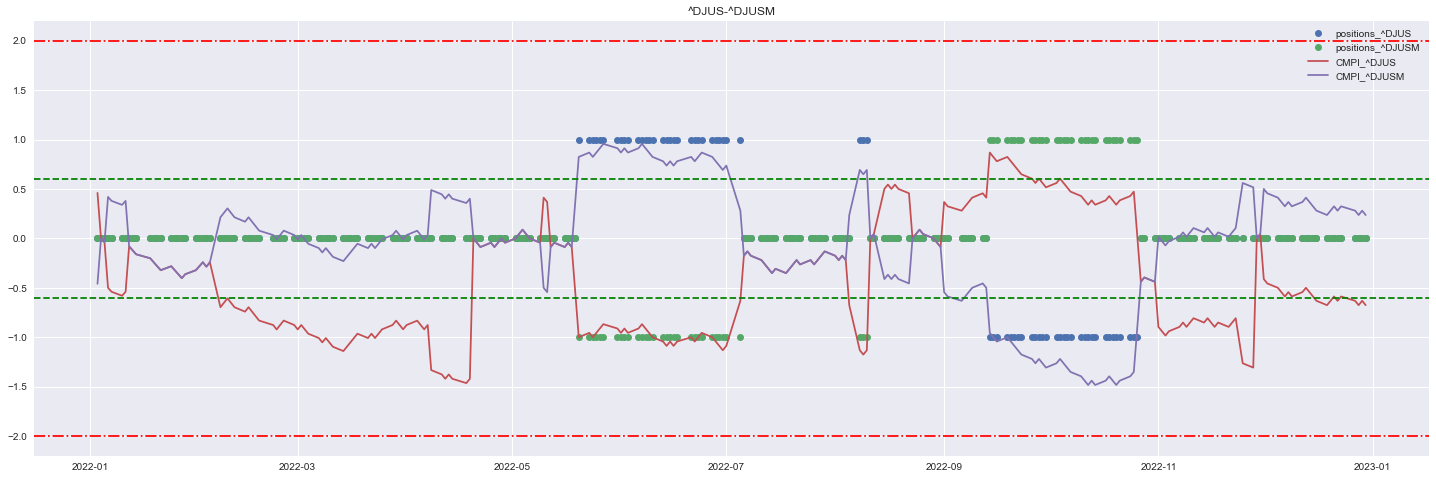

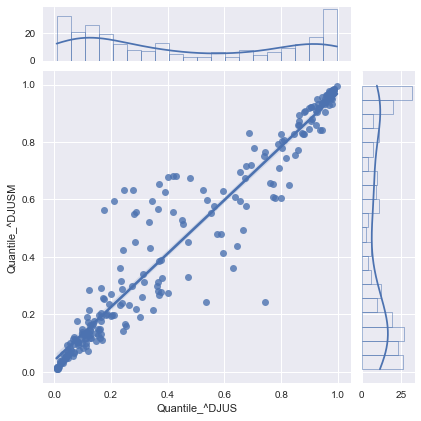

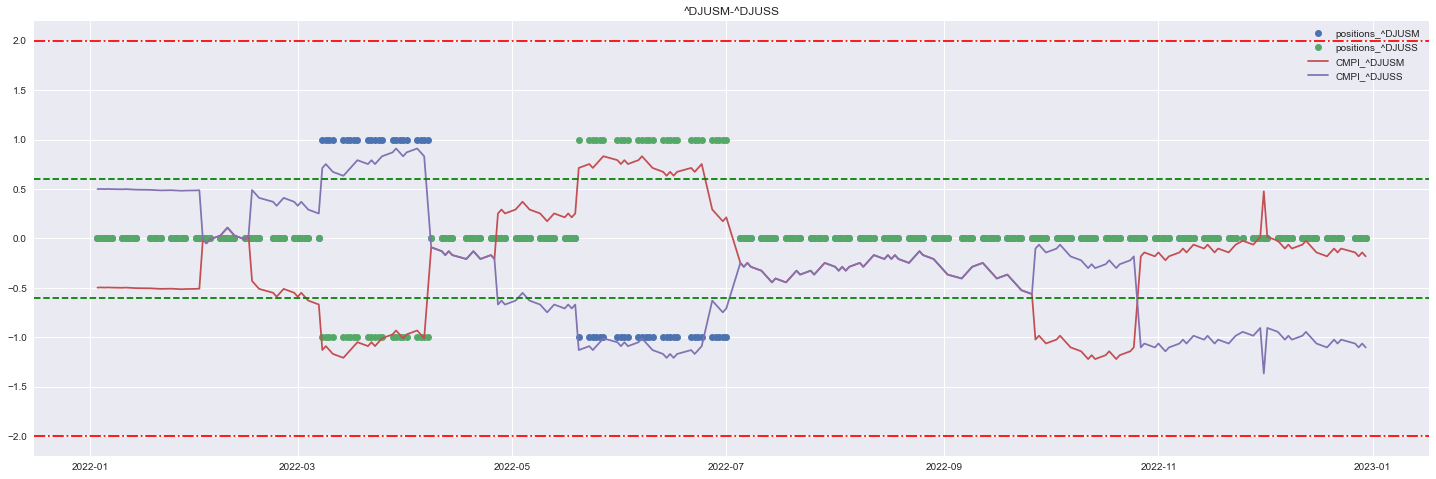

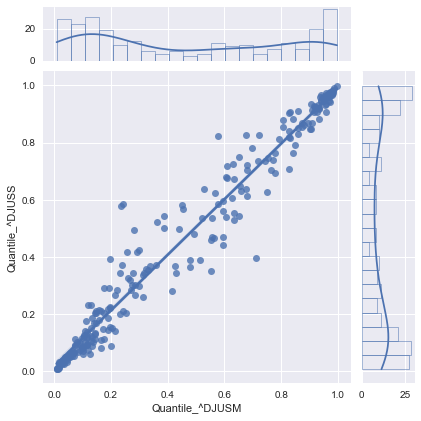

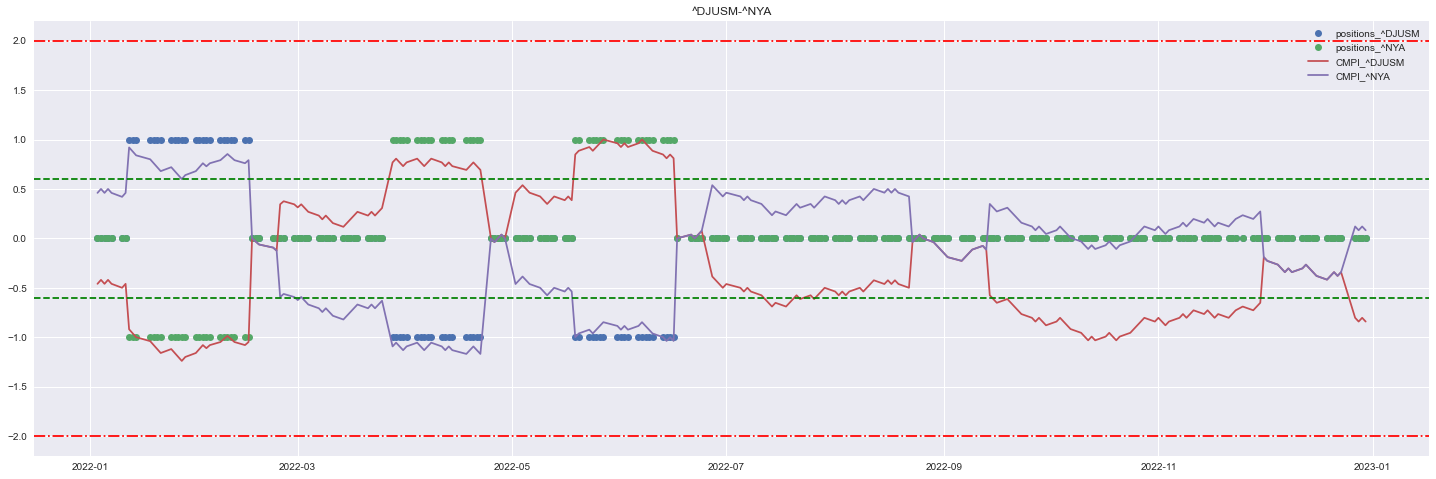

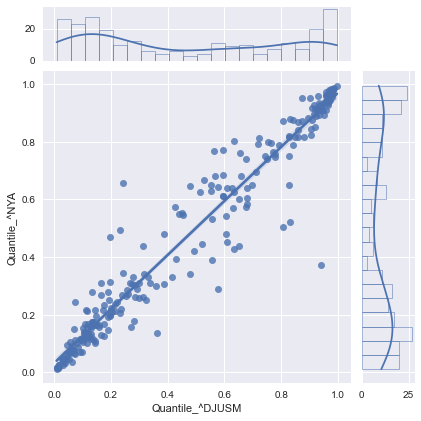

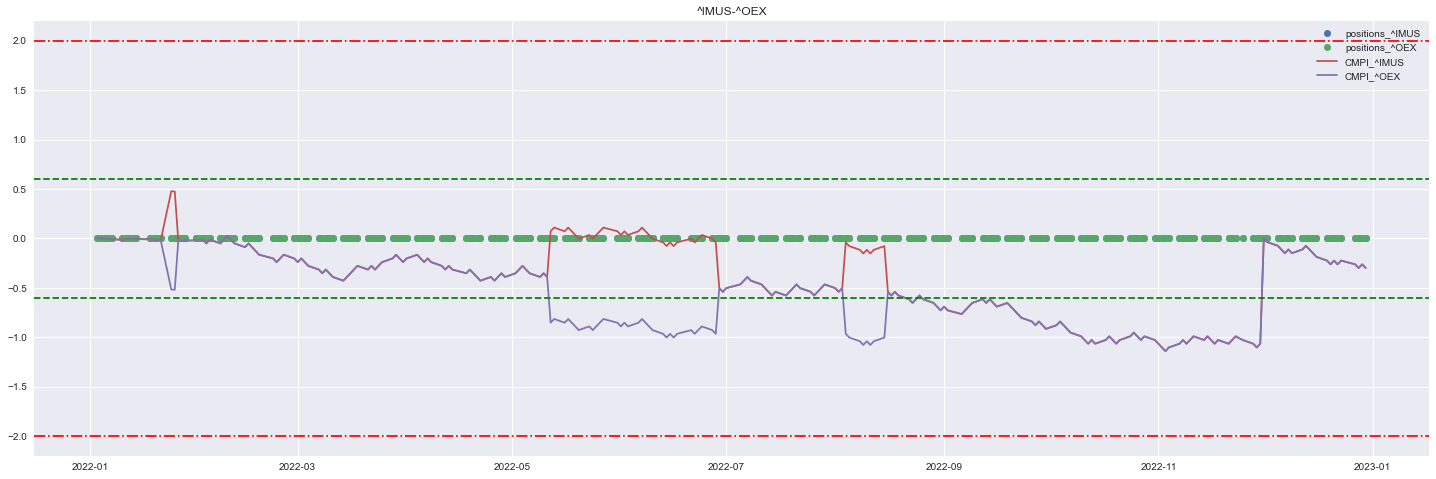

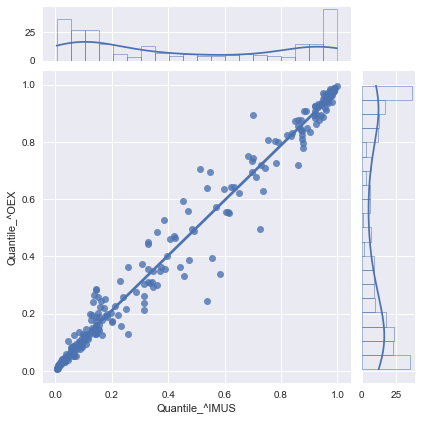

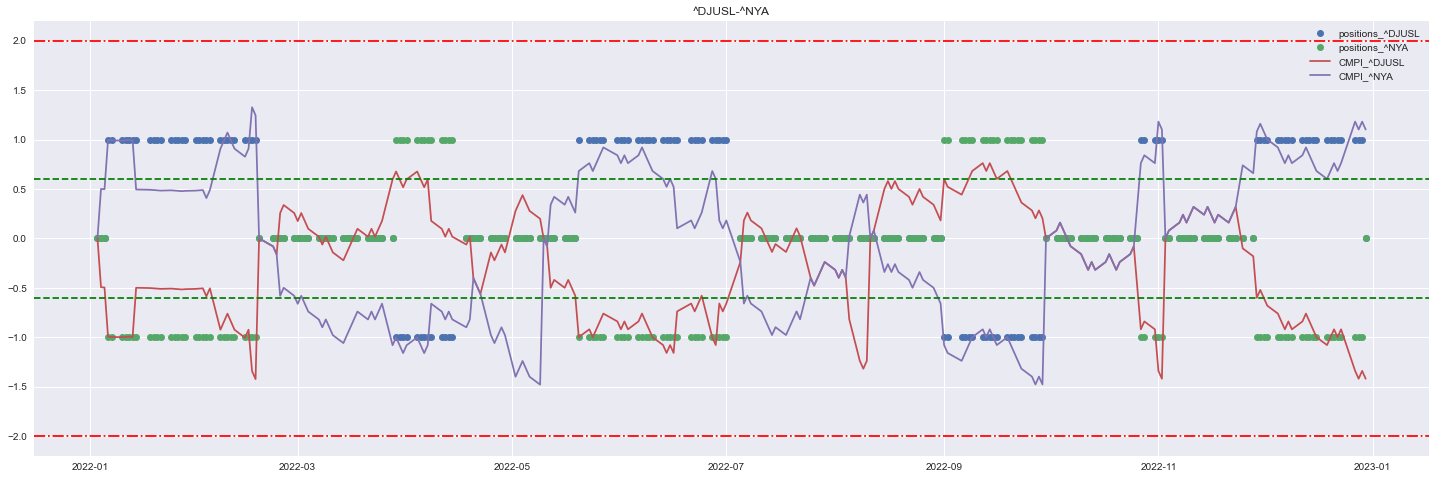

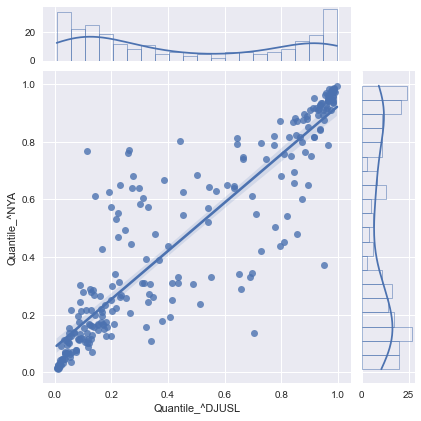

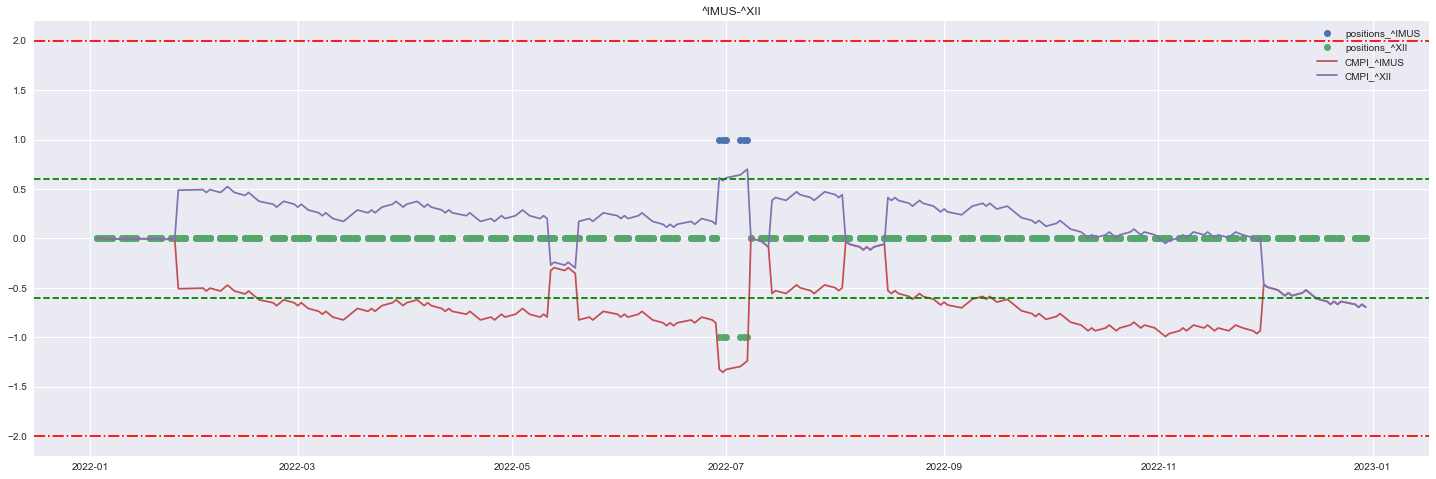

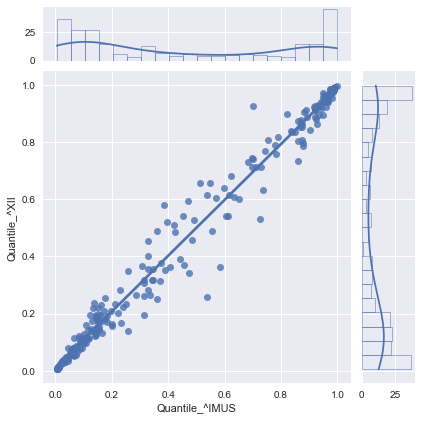

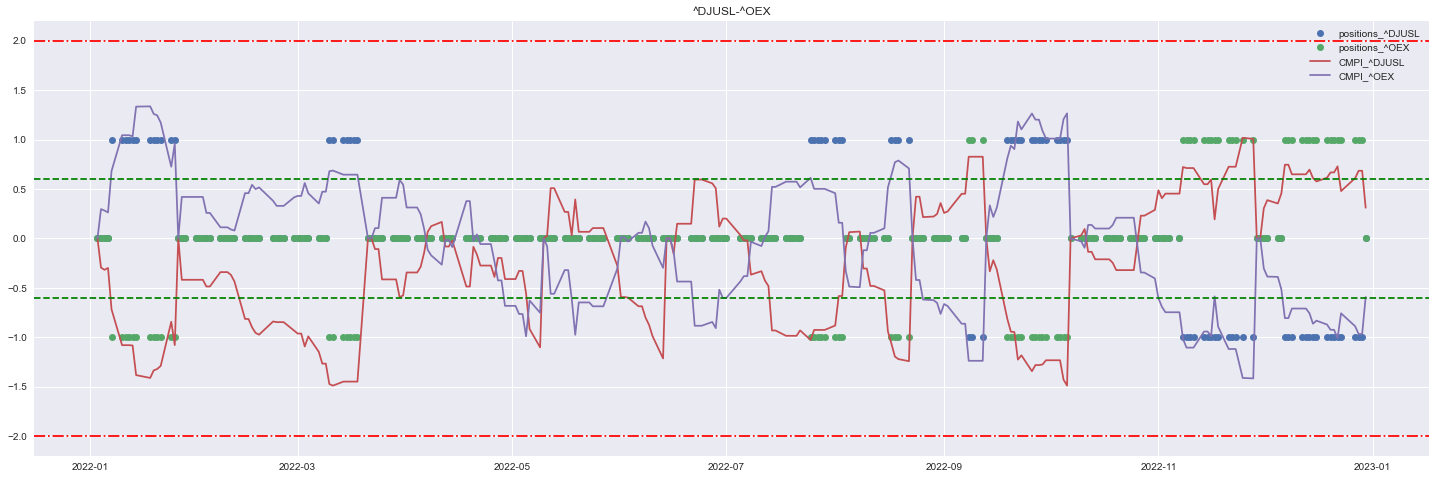

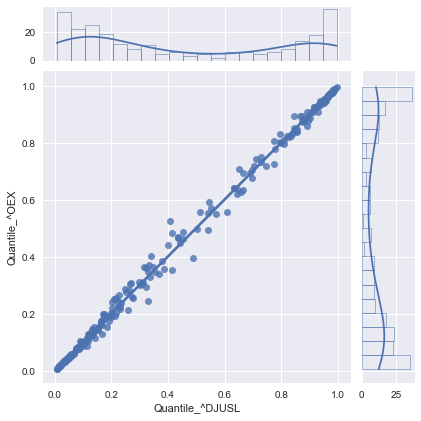

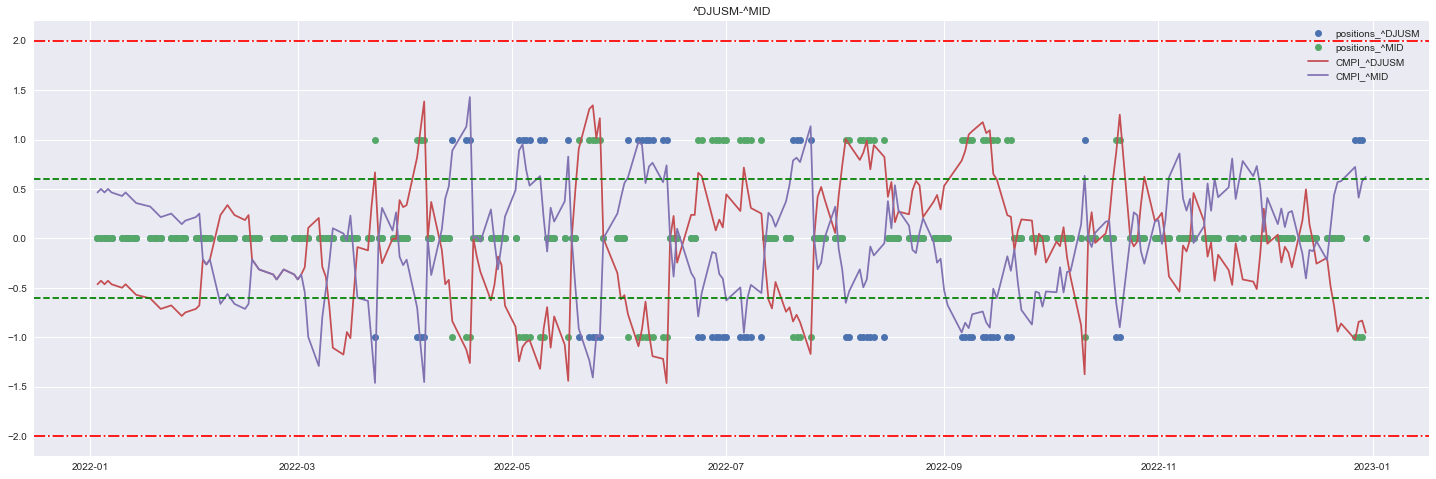

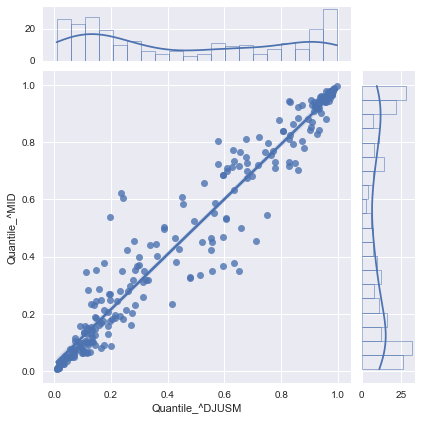

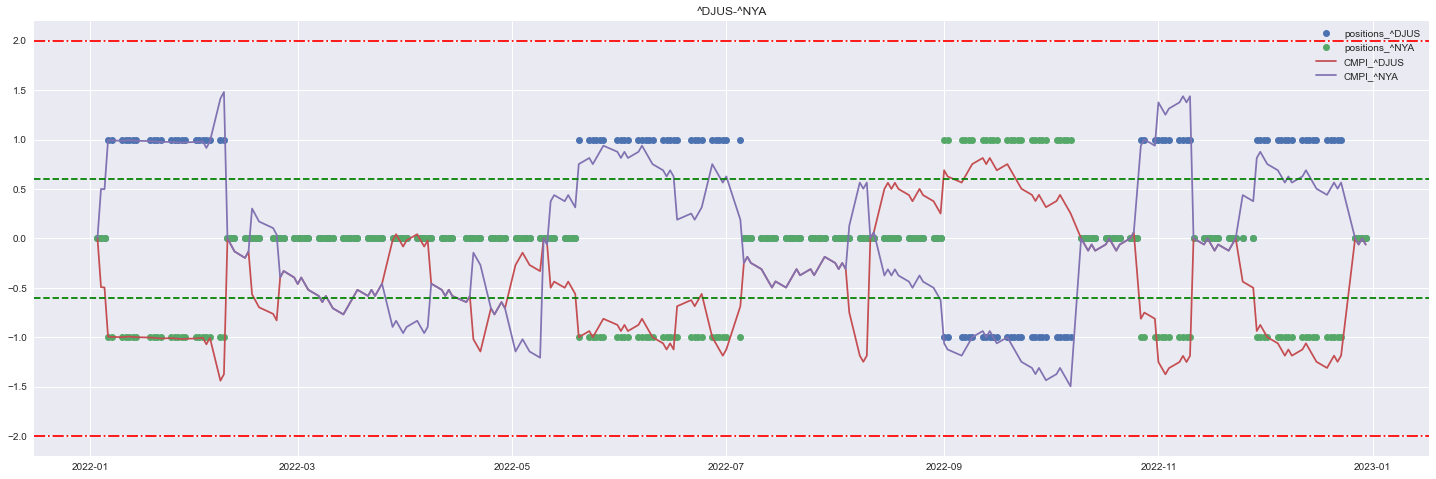

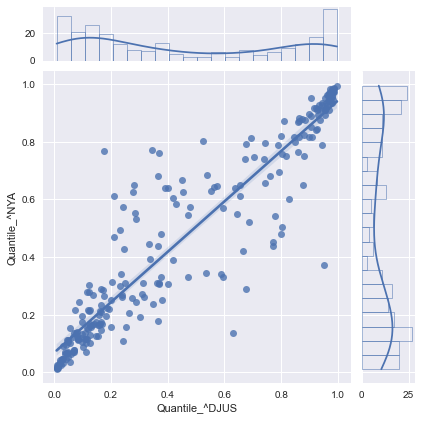

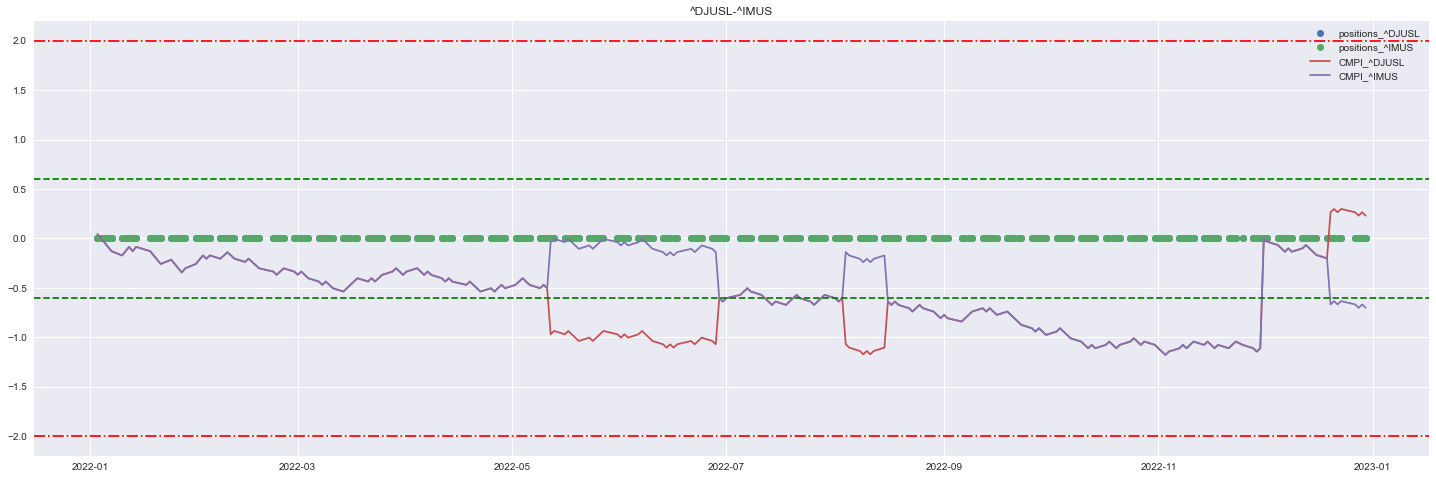

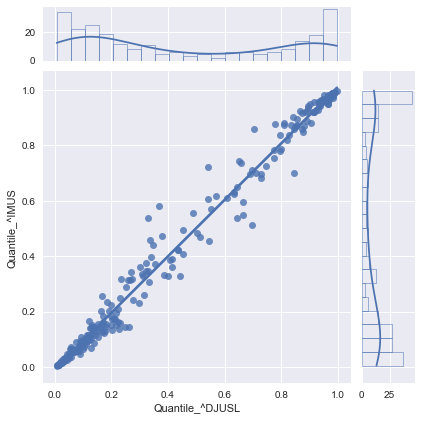

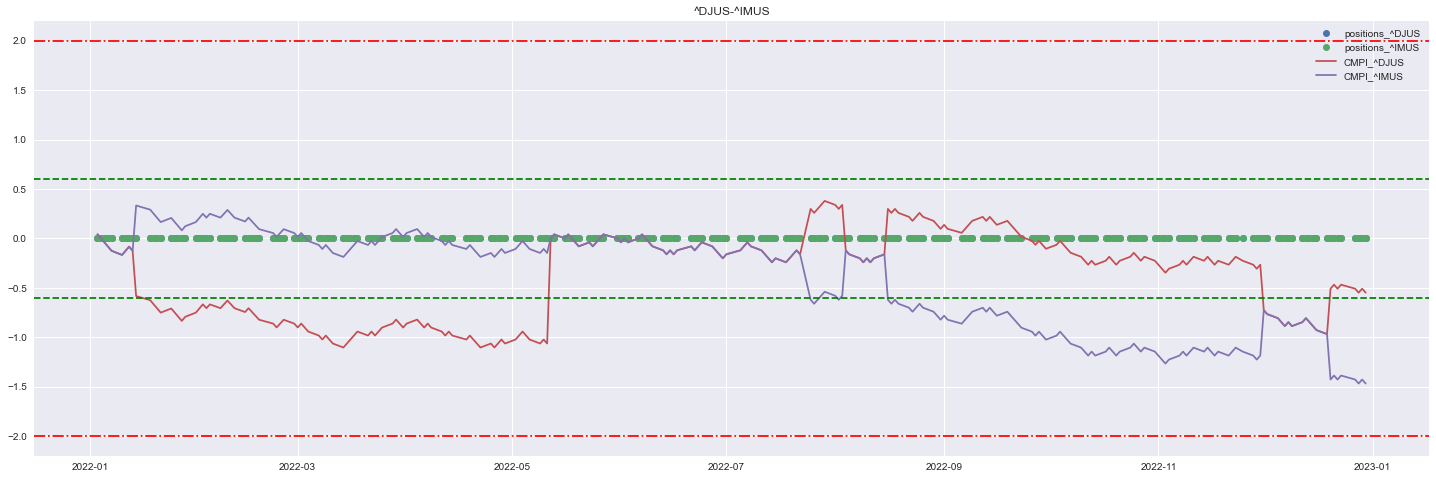

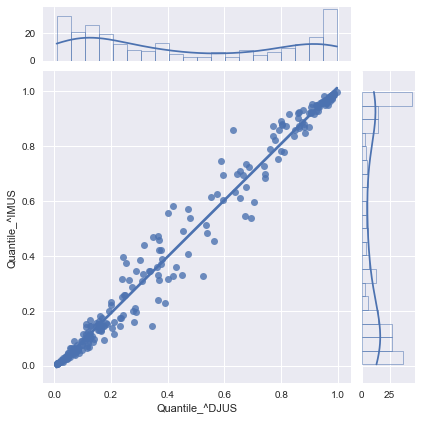

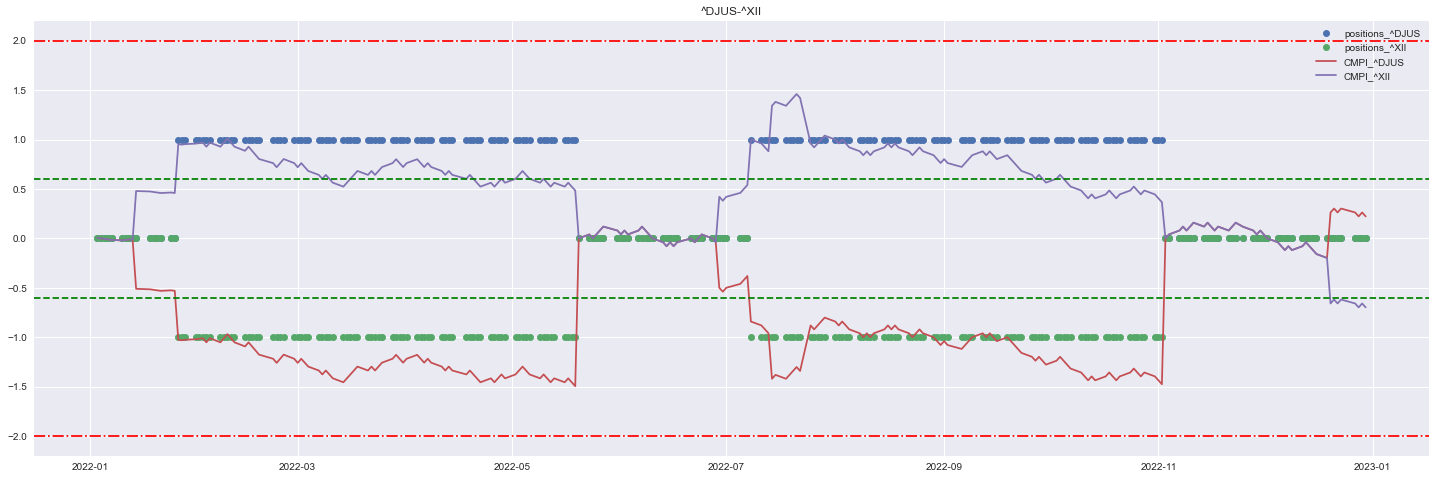

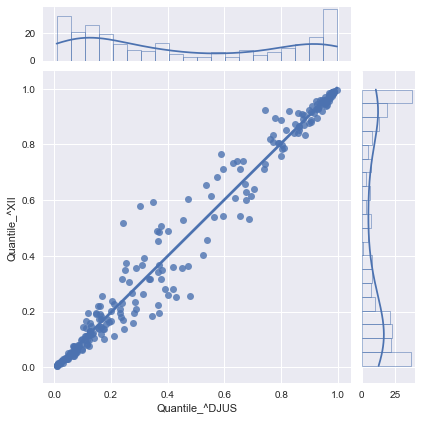

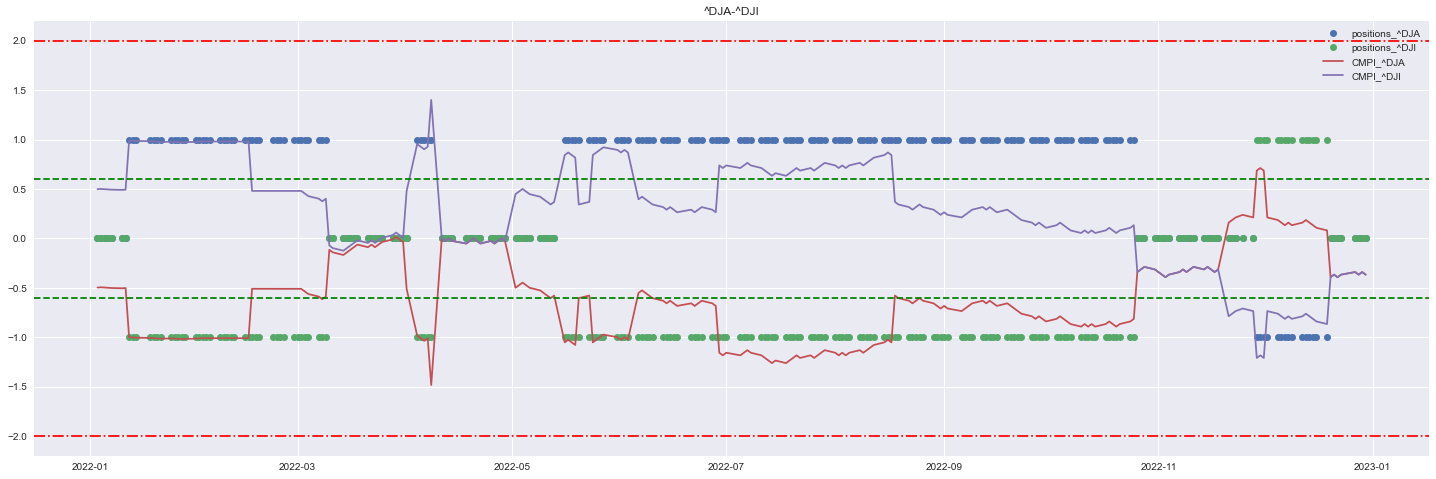

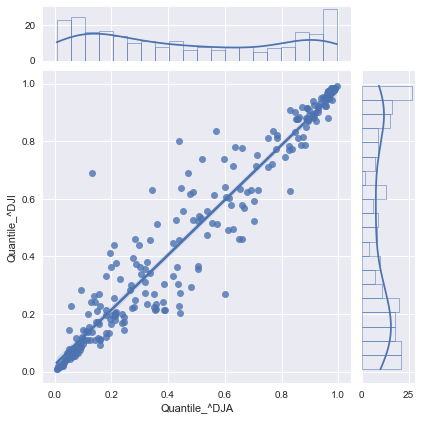

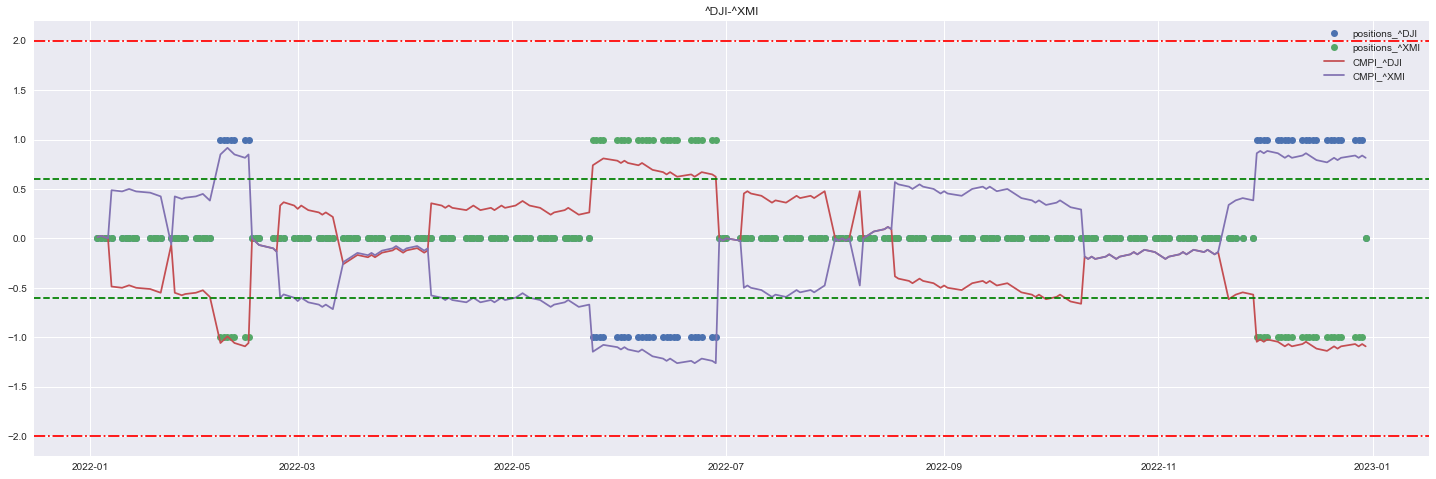

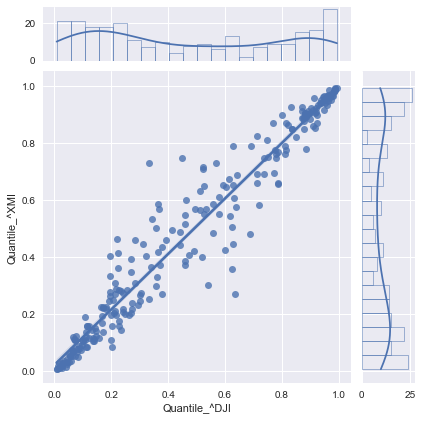

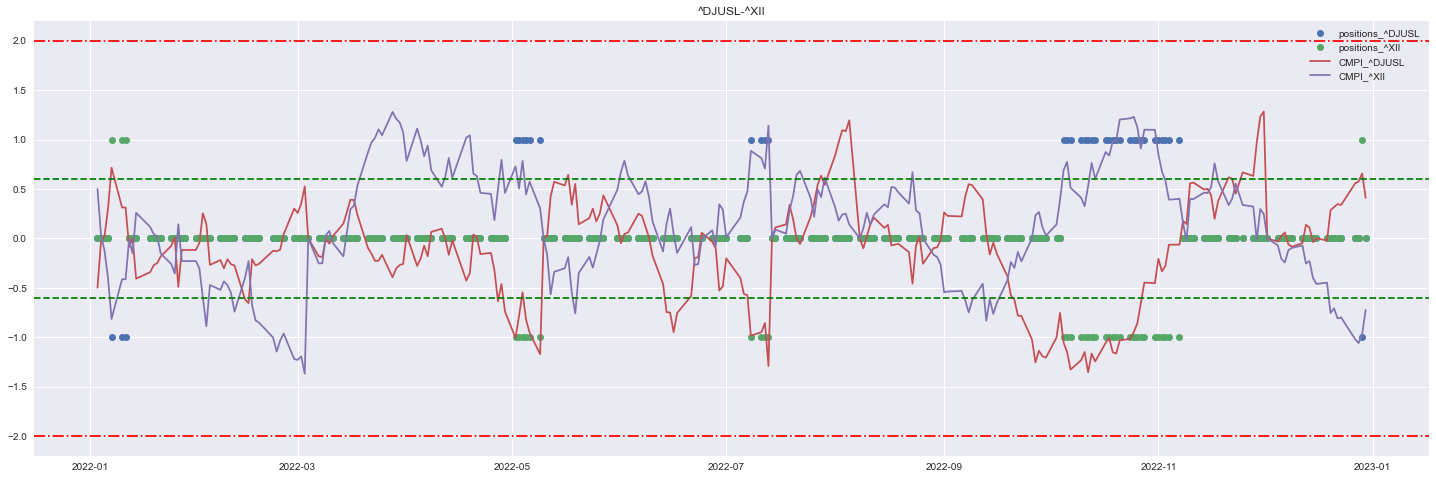

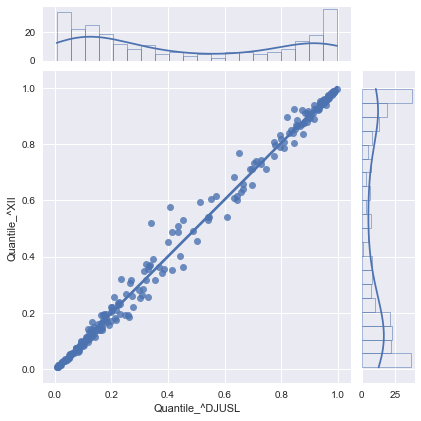

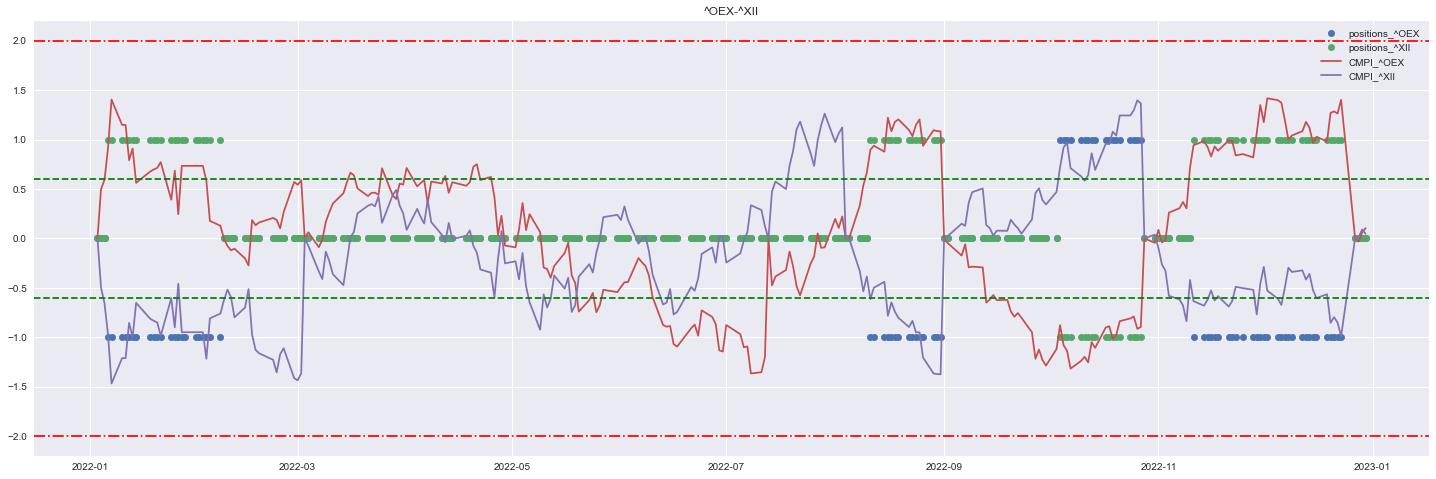

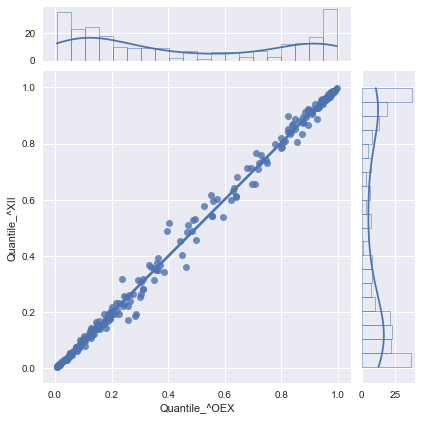

In [14]:
threshold = 0.6
trade_results = {}
df_pairs_metrics = pd.DataFrame(index=pairs_selected, columns=[
                                    'Cumulative_return', 'Maxdrawdown', 'Maxnum_consecutive_losses', 'Sharpe_ratio', 'Winning_Rate', 'Calmar Ratio'])

for pair in pairs_selected[:]:
    stock_1, stock_2 = parse_pair(pair)
    df_calculations, df_positions, df_returns = copula_trading(
        df_data_form, df_data_trade, df_copula_results, pair, threshold)

    trade_results[pair] = {'calculations': df_calculations,
                           'positions': df_positions,
                           'returns': df_returns,
                           'metrics': metrics(df_returns)}
    df_pairs_metrics.loc[pair] = trade_results[pair]['metrics'].values[0].tolist(
    )

    # NOTE: print metrics
    print(trade_results[pair]['metrics'])
    # NOTE: print MPI
    # print(trade_results[pair]['calculations'].iloc[:, -4:-2])
    # NOTE: print max CMPI
    print(trade_results[pair]['calculations'].iloc[:, -4:-2].max(axis=0))

    plt.figure(figsize=(25, 8))
    plt.title(pair)
    # NOTE: plot positions
    plt.plot(trade_results[pair]['positions'].iloc[:, :2], 'o')
    # NOTE: plot MPI
    plt.plot(trade_results[pair]['calculations'].iloc[:, -2:])
    plt.axhline(0.6, color='green', linestyle='--')
    plt.axhline(-0.6, color='green', linestyle='--')
    plt.axhline(2.0, color='red', linestyle='-.')
    plt.axhline(-2.0, color='red', linestyle='-.')
    plt.legend(['positions_'+stock_1, 'positions_' +
               stock_2, 'CMPI_'+stock_1, 'CMPI_'+stock_2])
    sns.jointplot(data=df_calculations.iloc[:, :2], x="Quantile_"+stock_1, y="Quantile_" +
                  stock_2, kind="reg", marginal_ticks=True, marginal_kws=dict(bins=20, fill=False))




In [19]:
df_pairs_metrics

,Cumulative_return,Maxdrawdown,Maxnum_consecutive_losses,Sharpe_ratio,Winning_Rate,Calmar Ratio
^DJGSP-^HUI,0.01823958,0.00981342,4.00000000,1.08438045,0.05179283,3.71727205
^DJI-^DJUS,-0.01044475,0.01560090,4.00000000,-0.57505536,0.03984064,-1.33899345
^DJUSS-^RUT,-0.03940931,0.04365914,5.00000000,-1.39613953,0.14741036,-1.80531810
^DJI-^DJUSL,-0.01156580,0.03897367,4.00000000,-0.28836281,0.12350598,-0.59351853
^DJUS-^DJUSL,0.03898223,0.00448760,4.00000000,2.80737720,0.24302789,17.37329176
^DJUS-^OEX,0.00000000,NaN,0.00000000,0.00000000,0.00000000,NaN
^MID-^RUT,-0.03965223,0.05975915,5.00000000,-0.97858322,0.27490040,-1.32706824
^DJI-^OEX,-0.00825863,0.01677045,4.00000000,-0.44145818,0.03187251,-0.98490266
^DJUSS-^MID,-0.01110988,0.02226539,4.00000000,-0.64357923,0.12749004,-0.99795008
^DJUS-^DJUSM,0.03397879,0.02084164,6.00000000,1.26490814,0.13545817,3.26066430


In [15]:
pairs_returns = []
for pair in pairs_selected:
    pairs_returns.append(trade_results[pair]['returns'])

print(pd.concat(pairs_returns,axis=1))
df_portfolio_return = pd.concat(pairs_returns,axis=1).mean(axis=1)
print(df_portfolio_return)

# df_portfolio_metrics = pd.DataFrame(columns=['Return','Sharpe Ratio'])
portfolio_return = df_portfolio_return.mean(axis=0)
portfolio_sharpeRatio = portfolio_return / df_portfolio_return.std(axis=0) * np.sqrt(252)

print(portfolio_return)
print(portfolio_sharpeRatio)

plt.figure()
profit_cum = ((np.exp(df_portfolio_return.sum(axis=1))-1)*10**6).cumsum()
print('cumsum', profit_cum)
plt.plot(profit_cum)


           Return_^DJGSP Return_^HUI Return_^DJI Return_^DJUS Return_^DJUSS  \
Date                                                                          
2022-01-03           NaN         NaN         NaN          NaN           NaN   
2022-01-04    0.00000000  0.00000000  0.00000000  -0.00000000    0.00000000   
2022-01-05   -0.00000000 -0.00000000 -0.00000000  -0.00000000   -0.00000000   
2022-01-06   -0.00000000 -0.00000000 -0.00000000  -0.00000000    0.00000000   
2022-01-07    0.00000000  0.00000000 -0.00000000  -0.00000000   -0.00000000   
...                  ...         ...         ...          ...           ...   
2022-12-23    0.00000000  0.00000000  0.00000000   0.00000000    0.00000000   
2022-12-27    0.00000000  0.00000000  0.00000000  -0.00000000   -0.00000000   
2022-12-28   -0.00000000 -0.00000000 -0.00000000  -0.00000000   -0.00000000   
2022-12-29    0.00000000  0.00000000  0.00000000   0.00000000    0.00000000   
2022-12-30   -0.00000000 -0.00000000 -0.00000000  -0

ValueError: No axis named 1 for object type Series

<Figure size 576x396 with 0 Axes>

Text(0.5, 1.0, 'Positions')

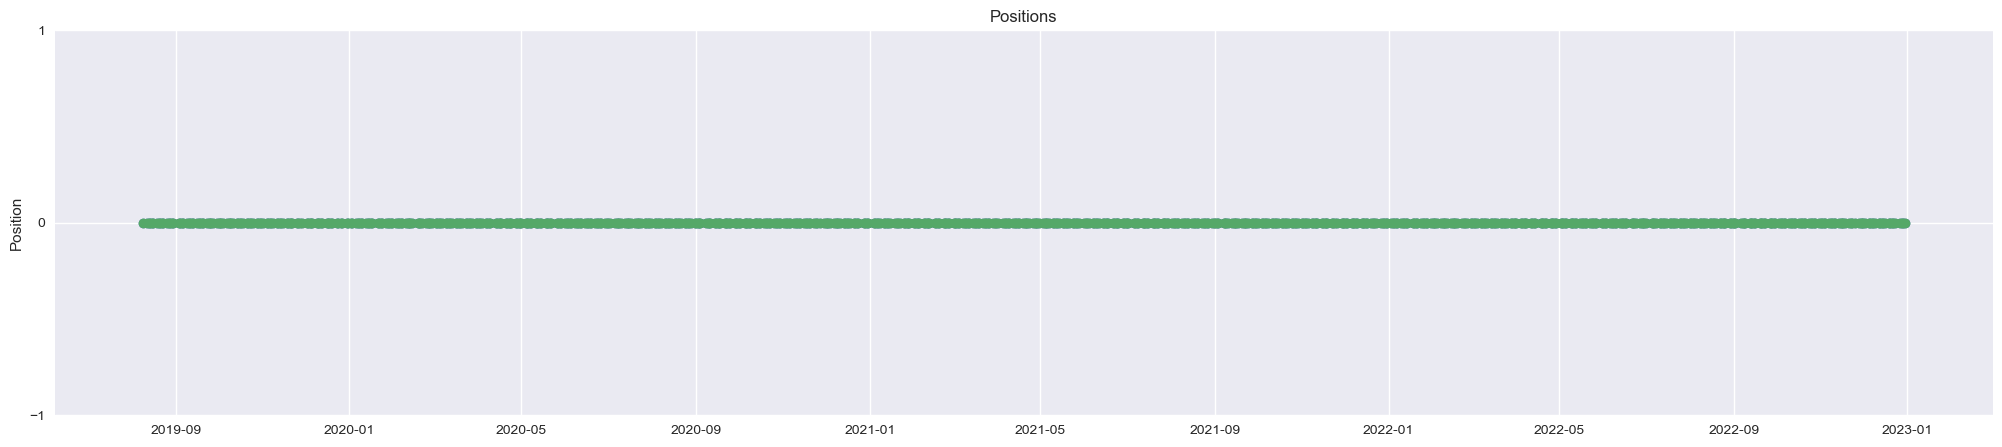

In [ ]:
plt.style.use('seaborn')
sns.set_style('darkgrid')
stock_1, stock_2 = parse_pair(pair)
df_positions[[stock_1, stock_2]]
# plot positions
plt.figure(figsize=(25, 5))
plt.plot(df_positions[[stock_1, stock_2]], 'o')
plt.yticks(np.arange(-1, 2, step=1))
plt.ylabel('Position')
plt.title('Positions')
